# Simple synthetic test to compare Steepest Descent to Newton's method

## Bott's method as a special case of the Steepest Descent method

We can further expand the method to cast Bott's method as a special case of the Steepest Descent algorithm. 
The step in the Steepest Descent method is

$$
\mathbf{p}^{k+1} 
= \mathbf{p}^k - \nabla \Theta(\mathbf{p}^k) 
= \mathbf{p}^k + 2\mathbf{A}^T \left[\mathbf{d}^o - \mathbf{d}(\mathbf{p}^k)\right]
$$

Bott's method would then be the special case of $\mathbf{A}$ being a diagonal matrix with 

$$
A_{ii} = \frac{1}{2(2 \pi G \rho_i)}.
$$

## Smoothness regularization in Steepest Descent

Test that the inversion by Steepest Descent works with smoothness regularization. Adding smoothness, the step becomes

$$
\mathbf{p}^{k+1} 
= \mathbf{p}^k - [\nabla \Theta(\mathbf{p}^k) + \mu \nabla \Phi_{smooth}(\mathbf{p}^k)]
$$

$$
\mathbf{p}^{k+1} 
= \mathbf{p}^k + 2\mathbf{A}^T \left[\mathbf{d}^o - \mathbf{d}(\mathbf{p}^k)\right]
- \mu 2 \mathbf{R}^T \mathbf{R} \mathbf{p}^k
$$

This is the approach adopted by Santos et al. (2015) (though they fail to mention it in the article).

## Using Gauss-Newton to impose smoothness


$$
\mathbf{p}^{k+1} 
= \mathbf{p}^k + \left[ \mathbf{A}^T \mathbf{A} + \mu \mathbf{R}^T \mathbf{R} \right]^{-1} 
\left[ \mathbf{A}^T [\mathbf{d}^o - \mathbf{d}(\mathbf{p}^k)] - \mu \mathbf{R}^T \mathbf{R}\mathbf{p}^k \right]
$$


## Create a synthetic model to test both methods

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import multiprocessing
import time
from IPython.display import Image
import matplotlib.pyplot as plt
from fatiando.inversion import Smoothness2D, LCurve
from fatiando.vis import myv, mpl
from fatiando.gravmag import tesseroid
from fatiando import utils, gridder
import fatiando
from tesseroid_mesh import TesseroidRelief
from moho import MohoGravityInvSpherical

In [2]:
print(fatiando.__version__)

16d4c082001a5a3a7ef85dc09d6cd28733ea82ce


In [3]:
# Get the number of cores in the computer to run the forward modeling in parallel
ncpu = multiprocessing.cpu_count()
ncpu

4

Define the computation grid.

In [4]:
shape = (30, 30)
# Make a regular grid inside an area
area = (-40, 40, 20, 60)
lon, lat, h = gridder.regular(area, shape, z=50e3)

In [5]:
# The model area is slightly larger because the points generated above are in the center of each cell.
dlon, dlat = gridder.spacing(area, shape)
modelarea = (area[0] - dlon/2, area[1] + dlon/2, area[2] - dlat/2, area[3] + dlat/2)
# Make a checkerboard relief undulating along the -35km height reference
f = 0.2
reference = -35e3
relief = 10e3*np.sin(f*lon)*np.cos(f*lat) + reference
# The density contrast is negative if the relief is below the reference
density = 600*np.ones_like(relief)
density[relief < reference] *= -1

In [6]:
model = TesseroidRelief(modelarea, shape, relief, reference, {'density': density})

In [7]:
def plot_result_3d(moho, fname):
    bounds = modelarea + (-20e3, -60e3)
    scale = (1, 1, 40) # Exaggerate the radial dimension
    datarange = np.abs([moho.props['density'].max(), moho.props['density'].min()]).max()
    scene = myv.figure(zdown=False)
    plot = myv.tesseroids(moho, 'density', scale=scale)
    plot.module_manager.scalar_lut_manager.show_legend = True
    plot.module_manager.scalar_lut_manager.lut_mode = 'RdYlBu'
    plot.module_manager.scalar_lut_manager.data_range = [-datarange, datarange]
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.minimum_size = np.array([1, 1])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.position2 = np.array([ 0.13741855,  0.64385382])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.position = np.array([ 0.03303258,  0.07342193])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.maximum_size = np.array([100000, 100000])
    plot.module_manager.scalar_lut_manager.label_text_property.color = (0, 0, 0)
    plot.module_manager.scalar_lut_manager.title_text_property.color = (0, 0, 0)
    scene.scene.camera.position = [2252864.9143914036, -5202911.2574882135, 8495162.9722945951]
    scene.scene.camera.focal_point = [3135763.9476126051, 1056258.4985192744, 829277.18542720564]
    scene.scene.camera.view_angle = 30.0
    scene.scene.camera.view_up = [0.6164057832087273, 0.57367112225287575, 0.53939350563383837]
    scene.scene.camera.clipping_range = [783483.44437851617, 16078402.004277557]
    scene.scene.camera.compute_view_plane_normal()
    scene.scene.render()
    myv.savefig(fname)
    #myv.show()
    myv.mlab.close()
    return Image(filename=fname)    

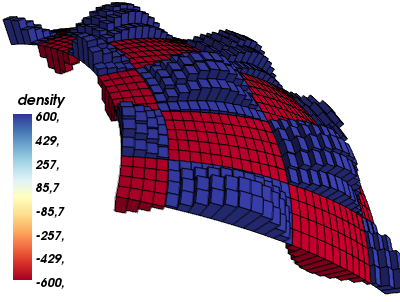

In [8]:
plot_result_3d(model, 'simple-synthetic-model.png')

In [9]:
gz = tesseroid.gz(lon, lat, h, model, njobs=ncpu)
gz = utils.contaminate(gz, 5, seed=0)

/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/matplotlib/tri/triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


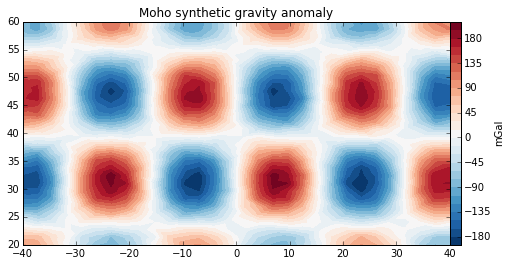

In [10]:
plt.figure(figsize=(9, 4))
plt.title('Moho synthetic gravity anomaly')
plt.tricontourf(lon, lat, gz, 30, cmap='RdBu_r')
plt.colorbar(pad=0).set_label('mGal')

## Inversion setup

In [11]:
# Make a mesh
mesh = model.copy(deep=True)
mesh.props['density'] = 600*np.ones(mesh.size)
initial = np.ones(mesh.size)*(mesh.reference - 30e3)

In [12]:
test_lon, test_lat, test_h = gridder.regular(area, (50, 50), z=10e3)
test_data = tesseroid.gz(test_lon, test_lat, test_h, model, njobs=ncpu)
test_data = utils.contaminate(test_data, 5, seed=10)

In [13]:
# The cross-validation solver
test_set = MohoGravityInvSpherical(test_lon, test_lat, test_h, test_data, mesh)

In [14]:
misfit = MohoGravityInvSpherical(lon, lat, h, gz, mesh)
regul = Smoothness2D(mesh.shape)

In [15]:
def fit_test(args):
    mu, config, test_set = args
    solver = (misfit + mu*regul).config(**config).fit()
    rms = test_set.value(solver.p_)/test_set.ndata
    return rms, solver

In [16]:
def cross_validation(regul_params, config, test_set):
    n = len(regul_params)
    args = zip(regul_params, [config]*n, [test_set]*n)
    pool = multiprocessing.Pool(ncpu)
    results = pool.map(fit_test, args)
    pool.close()
    scores, solvers = zip(*results)
    best = np.argmin(scores)
    return best, scores, solvers    

In [17]:
def plot_result_maps(solver):
    predicted = solver[0].predicted()
    residuals = solver[0].residuals()
    moho = solver.estimate_
    plt.figure(figsize=(9, 4))
    plt.title('Observed (color) and predicted (contour) data')
    plt.axis('scaled')
    levels = mpl.contourf(lon, lat, gz, shape, 12, cmap='Blues_r')
    plt.colorbar(pad=0).set_label('mGal')
    mpl.contour(lon, lat, predicted, shape, levels)
    plt.figure()
    plt.title('Residuals | mean={:.3f} std={:.3f}'.format(residuals.mean(), residuals.std()))
    plt.hist(residuals, bins=20)
    plt.figure(figsize=(9, 4))
    plt.title("Estimated Moho depth")
    plt.axis('scaled')
    mpl.pcolor(lon - dlon/2, lat - dlat/2, -0.001*moho.relief, shape, cmap='Blues_r')
    plt.colorbar(pad=0).set_label('km')
    mpl.square(model[0].get_bounds()[:4])

## Steepest Descent

In [18]:
regul_params = np.logspace(-6, -1, 10)
regul_params

array([  1.00000000e-06,   3.59381366e-06,   1.29154967e-05,
         4.64158883e-05,   1.66810054e-04,   5.99484250e-04,
         2.15443469e-03,   7.74263683e-03,   2.78255940e-02,
         1.00000000e-01])

In [19]:
steep_config = dict(method='steepest', initial=initial, tol=0.2, maxit=10, linesearch=False)

In [20]:
%time best, scores, solvers = cross_validation(regul_params, steep_config, test_set)

CPU times: user 33.6 ms, sys: 28.3 ms, total: 61.9 ms
Wall time: 49.2 s


/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:447: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:447: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:447: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:447: RuntimeWarning: Exited because maximum iterations reached. Might not

In [21]:
steep = solvers[best]

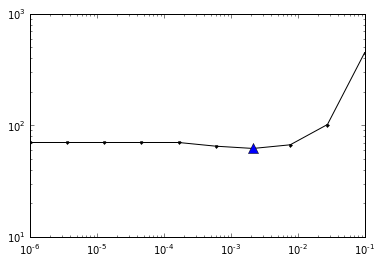

In [22]:
plt.figure()
plt.plot(regul_params, scores, '.-k')
plt.plot(regul_params[best], scores[best], '^b', markersize=10)
plt.xscale('log')
plt.yscale('log')

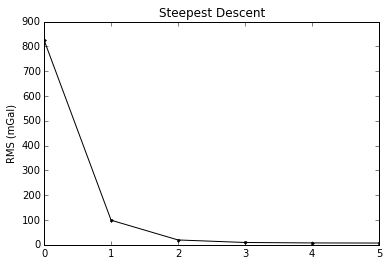

In [23]:
plt.figure()
ax1 = plt.subplot(111)
rms = np.sqrt(steep.stats_['objective'])/np.sqrt(misfit.ndata)
ax1.plot(rms, '.k-')
ax1.set_ylabel('RMS (mGal)')
ax1.set_title(steep.stats_['method'])

/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


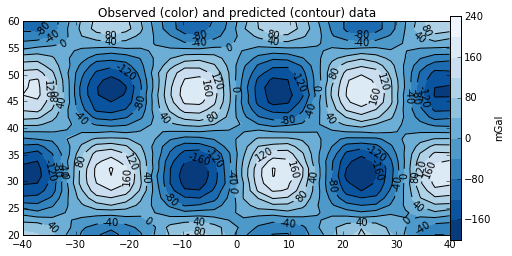

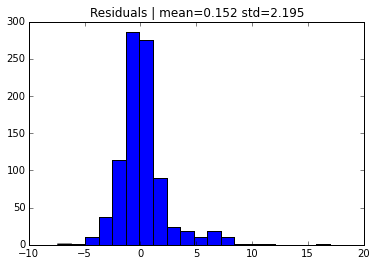

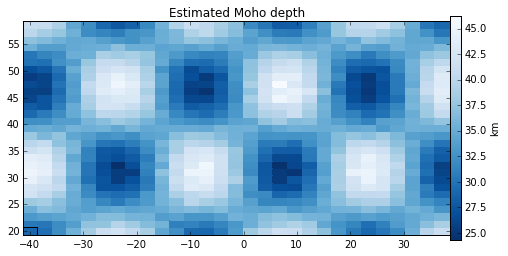

In [24]:
plot_result_maps(steep)

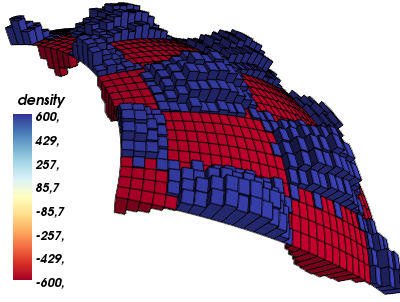

In [25]:
plot_result_3d(steep.estimate_, 'simple-synthetic-steepest.png')

**Notice that even when underfitting the data, the solution is still not properly smooth.** 
So it seems that using only the gradient of the smoothness regularization is not enough to fully smooth the solution. The results in Santos et al 2015 are smooth, though. Maybe that's because they start out with a regularized solution from the start.

## Newton

In [26]:
regul_params = np.logspace(-6, -1, 10)
regul_params

array([  1.00000000e-06,   3.59381366e-06,   1.29154967e-05,
         4.64158883e-05,   1.66810054e-04,   5.99484250e-04,
         2.15443469e-03,   7.74263683e-03,   2.78255940e-02,
         1.00000000e-01])

In [27]:
newton_config = dict(method='newton', initial=initial, tol=0.2, maxit=10)

In [28]:
%time best, scores, solvers = cross_validation(regul_params, newton_config, test_set)

CPU times: user 34.9 ms, sys: 31.7 ms, total: 66.7 ms
Wall time: 53.2 s


/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:185: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:185: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:185: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:185: RuntimeWarning: Exited because maximum iterations reached. Might not

In [29]:
newton = solvers[best]

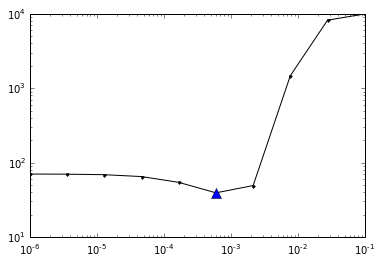

In [30]:
plt.figure()
plt.plot(regul_params, scores, '.-k')
plt.plot(regul_params[best], scores[best], '^b', markersize=10)
plt.xscale('log')
plt.yscale('log')

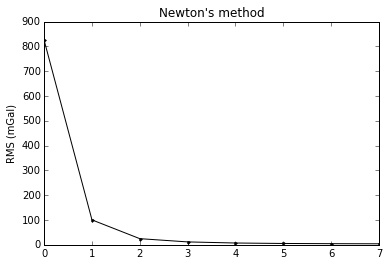

In [31]:
plt.figure()
ax1 = plt.subplot(111)
rms = np.sqrt(newton.stats_['objective'])/np.sqrt(misfit.ndata)
ax1.plot(rms, '.k-')
ax1.set_ylabel('RMS (mGal)')
ax1.set_title(newton.stats_['method'])

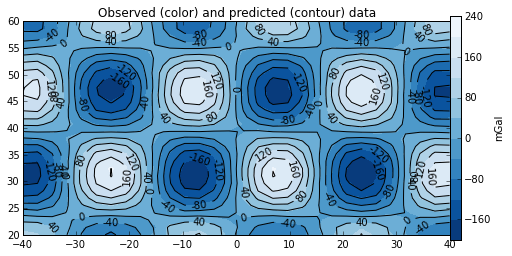

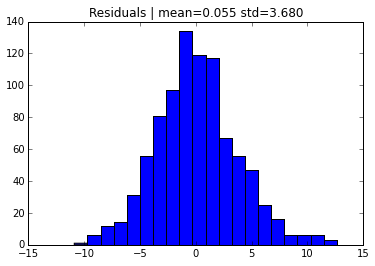

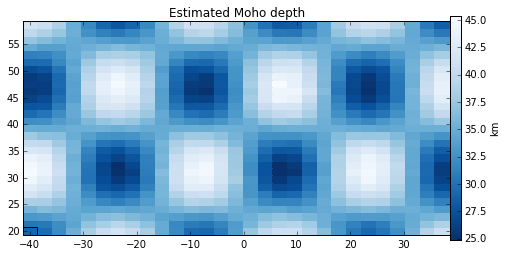

In [32]:
plot_result_maps(newton)

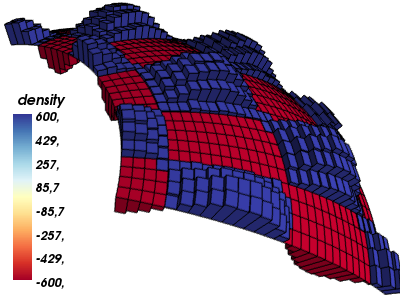

In [33]:
plot_result_3d(newton.estimate_, 'simple-synthetic-newton.png')

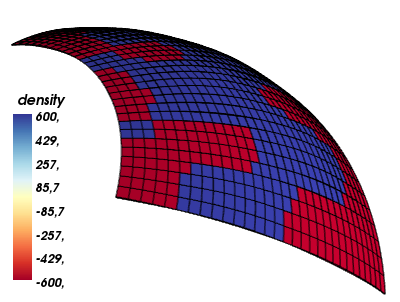

In [34]:
plot_result_3d(solvers[-1].estimate_, 'simple-synthetic-newton.png')

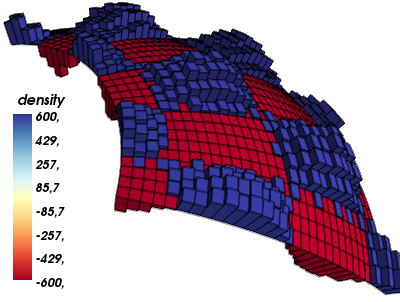

In [35]:
plot_result_3d(solvers[0].estimate_, 'simple-synthetic-newton.png')